## Forecast the CocaCola prices and Airlines Passengers data set. Prepare a document for each model explaining 
## how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
## Forecasting.

# 

#

### Forcasting the CocaCola prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from statsmodels.tsa.stattools import adfuller,acf,pacf 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
df=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [3]:
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
temp = df.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')

C:\Users\Hp\AppData\Local\Temp\ipykernel_13140\2357995506.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  temp = df.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')


In [5]:
df['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')

In [6]:
df.head()

,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [7]:
df=df.drop(['Quarter'],axis=1)

In [8]:
df.head()

,Sales,quater
0,1734.827000,Jan-1986
1,2244.960999,Apr-1986
2,2533.804993,Jul-1986
3,2154.962997,Oct-1986
4,1547.818996,Jan-1987


In [9]:
df['quater']=pd.to_datetime(df.quater)

In [10]:
df.head()

,Sales,quater
0,1734.827000,1986-01-01
1,2244.960999,1986-04-01
2,2533.804993,1986-07-01
3,2154.962997,1986-10-01
4,1547.818996,1987-01-01


In [11]:
df.set_index('quater',inplace=True)

In [12]:
df.head()

,Sales
quater,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


<Axes: xlabel='quater'>

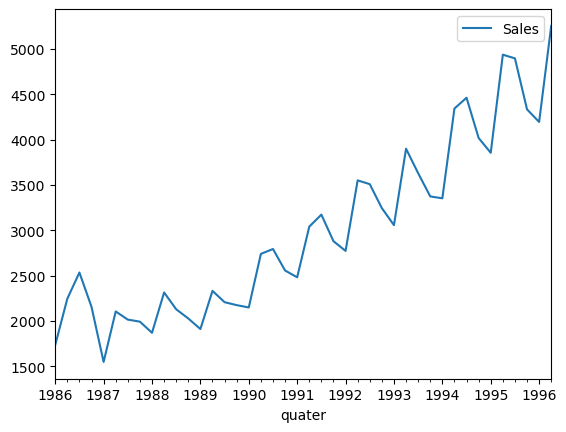

In [13]:
df.plot()

In [14]:
result=seasonal_decompose(df['Sales'],model='multiplicative')

<Axes: xlabel='quater'>

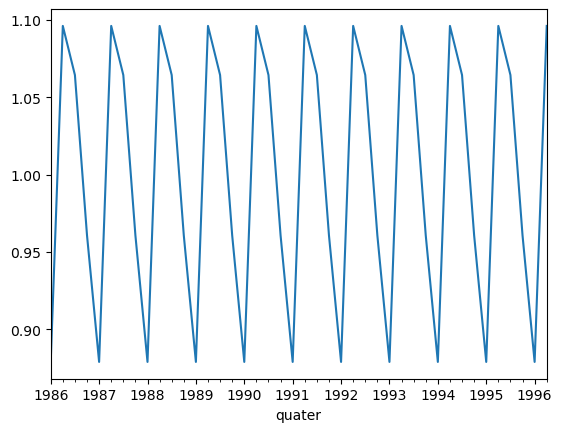

In [15]:
result.seasonal.plot()

<Axes: xlabel='quater'>

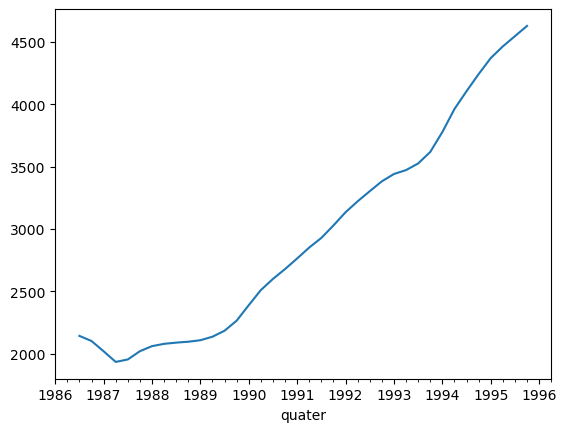

In [16]:
result.trend.plot()

<Axes: xlabel='quater'>

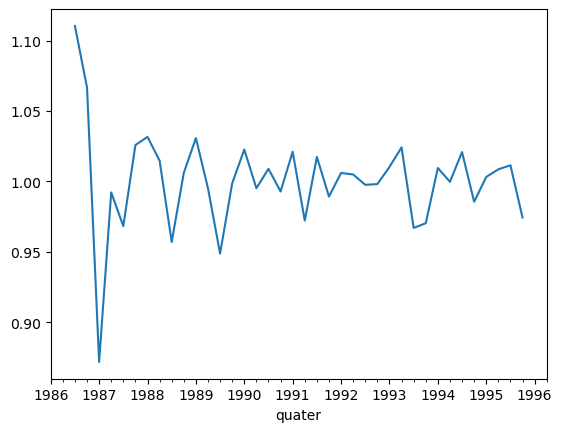

In [17]:
result.resid.plot()

#### H0 - Data is not stationary
#### H1 - Data is stationary

In [18]:
test=adfuller(df)
output=pd.Series(test[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for i,j in test[4].items():
    output['Critical Value (%s)'%i]=j
print(output)

Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


#### P-value is greater then critical value we accept null Hypothisis
#### Hence data is not stationary

#### To make data stationary we go for differencing and log_transformation

##### * Log Transformation

In [19]:
Trans_data=np.log(df[['Sales']])

<Axes: xlabel='quater'>

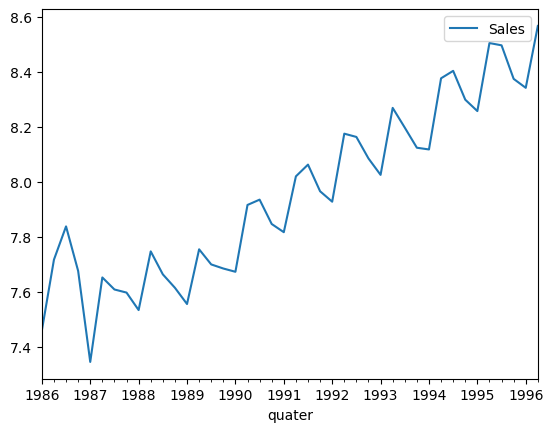

In [20]:
Trans_data.plot()

##### Differencing

In [21]:
Stationary=Trans_data.iloc[:,:]-Trans_data.iloc[:,:].rolling(window=4).mean()

In [22]:
Stationary.head(10)

,Sales
quater,
1986-01-01,NaN
1986-04-01,NaN
1986-07-01,NaN
1986-10-01,0.003501
1987-01-01,-0.298911
1987-04-01,0.024441
1987-07-01,0.038063
1987-10-01,0.046463
1988-01-01,-0.064265


In [23]:
Stationary.dropna(inplace=True)

In [24]:
Stationary.head(6)

,Sales
quater,
1986-10-01,0.003501
1987-01-01,-0.298911
1987-04-01,0.024441
1987-07-01,0.038063
1987-10-01,0.046463
1988-01-01,-0.064265


In [25]:
test=adfuller(Stationary)
output=pd.Series(test[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for i,j in test[4].items():
    output['Critical Value (%s)'%i]=j
print(output)

Test Statistic                 -4.715896
p-value                         0.000079
#Lags Used                      4.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


##### Now the data is Stationsry

<Axes: xlabel='quater'>

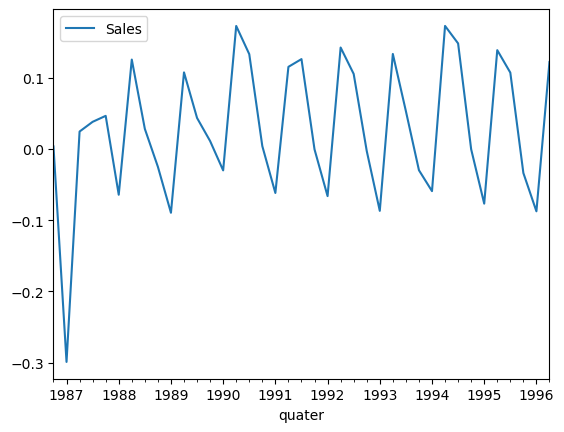

In [26]:
Stationary.plot()

#### Plot the ACF and PACF curve for finding optimal 'p'&'q' values

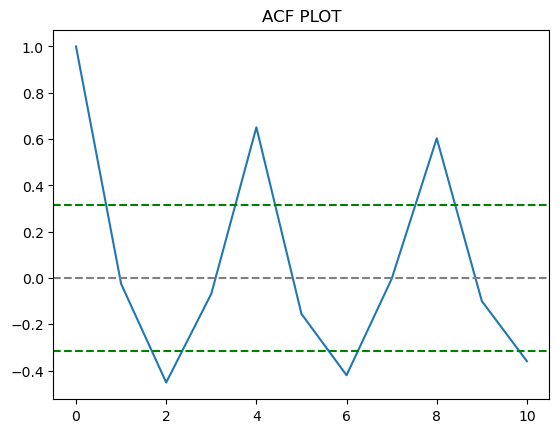

In [27]:
#Plotting the ACF curve

plt.plot(np.arange(0,11),acf(Stationary,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
#confidence intervals
plt.axhline(y=-1.96/np.sqrt(len(Stationary)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(Stationary)),linestyle='--',color='green')
plt.title('ACF PLOT')
plt.show()

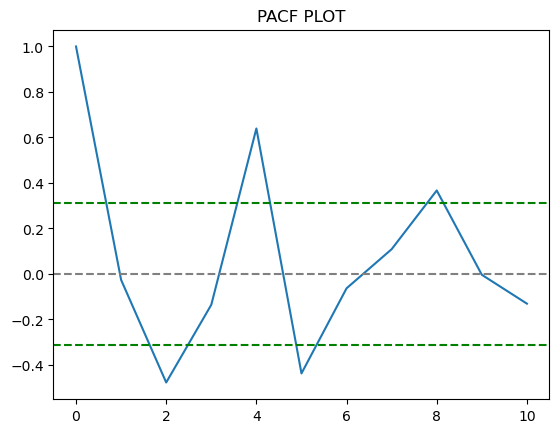

In [28]:
#Plotting the PACF curve

plt.plot(np.arange(0,11),pacf(Stationary,nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
#confidence intervals
plt.axhline(y=-1.96/np.sqrt(len(Stationary)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(Stationary)),linestyle='--',color='green')
plt.title('PACF PLOT')
plt.show()

In [29]:
train_size=int(len(Stationary)*0.75)

In [30]:
train_data=Stationary[:train_size]
test_data=Stationary[train_size:]

In [31]:
y_train=train_data['Sales']
y_test=test_data['Sales']

### SARIMAX

In [87]:
model=sm.tsa.SARIMAX(y_train,order=(1,1,1),seasonal_order=(1,1,1,4))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [88]:
results=model.fit()

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## Method 1

In [89]:
pred=results.predict(start=y_test.index[0],end=y_test.index[-1]) 

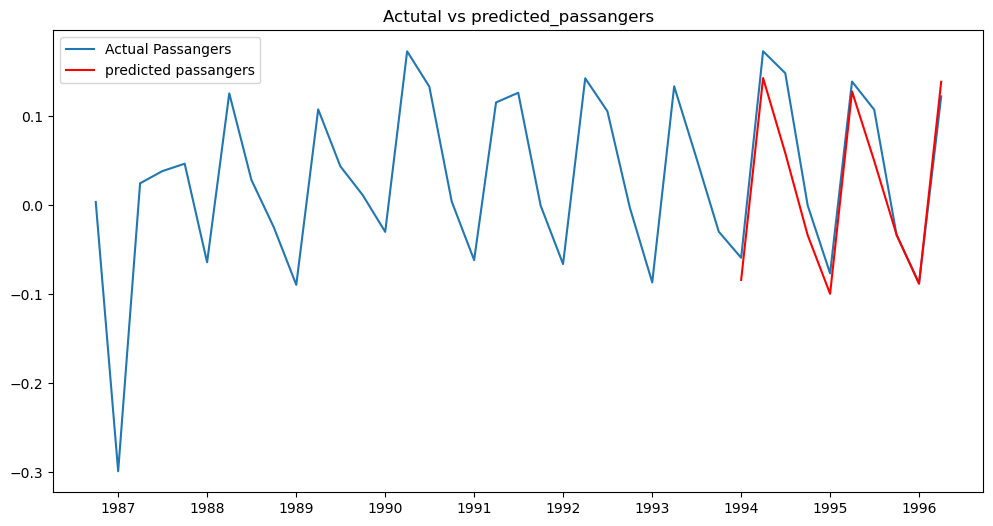

In [93]:
plt.figure(figsize=(12,6))
plt.plot(Stationary,label='Actual Passangers')
plt.plot(pred,label='predicted passangers',color='red')
plt.legend()
plt.title('Actutal vs predicted_passangers')
plt.show()

In [91]:
rmse = sqrt(mean_squared_error(test_data['Sales'], pred))

In [92]:
rmse

0.03860474814840103

# 

## Method 2

In [34]:
forecast_steps=len(test_data)

In [35]:
predictions=results.get_forecast(steps=forecast_steps)

In [36]:
predicted_mean=predictions.predicted_mean

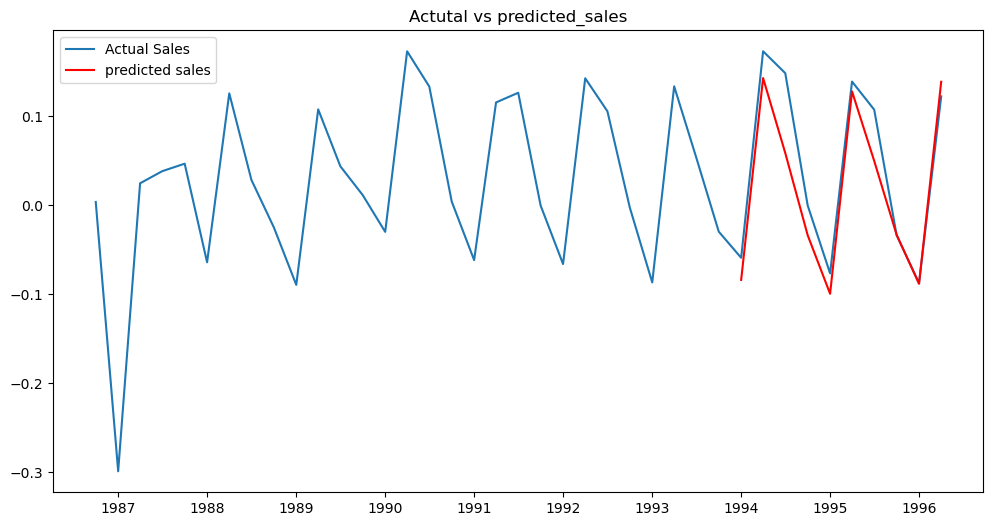

In [37]:
plt.figure(figsize=(12,6))
plt.plot(Stationary['Sales'],label='Actual Sales')
plt.plot(test_data.index,list(predicted_mean),label='predicted sales',color='red')
plt.legend()
plt.title('Actutal vs predicted_sales')
plt.show()

In [38]:
rmse = sqrt(mean_squared_error(test_data['Sales'], predicted_mean))

In [39]:
rmse

0.03860474814840103

### ARIMA

In [40]:
model2=sm.tsa.ARIMA(y_train,order=(1,1,1))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [41]:
results=model2.fit()

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


#### By setting disp to -1, you're telling the ARIMA model to fit silently without displaying optimization-related messages.

In [42]:
predicted_mean = results.forecast(steps=forecast_steps)

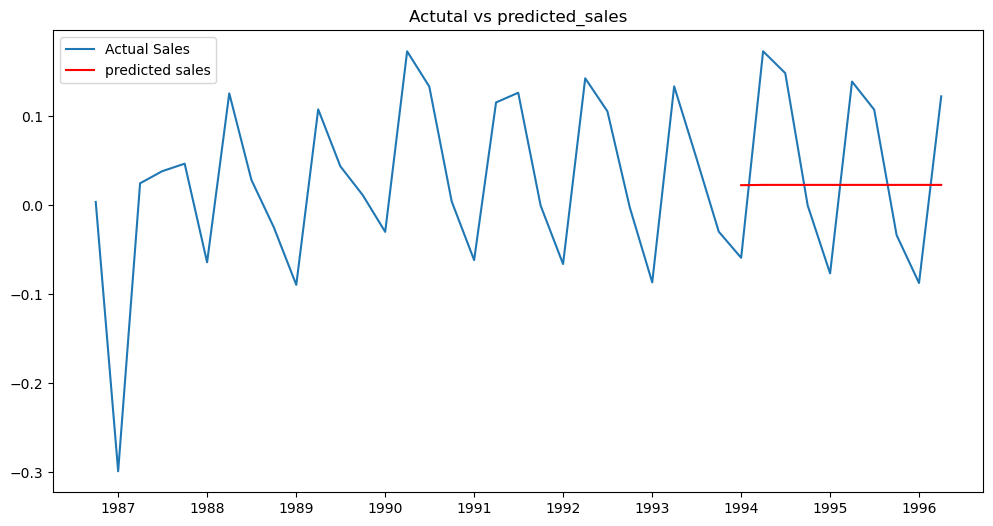

In [43]:
plt.figure(figsize=(12,6))
plt.plot(Stationary['Sales'],label='Actual Sales')
plt.plot(test_data.index,list(predicted_mean),label='predicted sales',color='red')
plt.legend()
plt.title('Actutal vs predicted_sales')
plt.show()

In [44]:
rmse = sqrt(mean_squared_error(test_data['Sales'], predicted_mean))

In [45]:
rmse

0.10054792868879227

#

### Forecasting the Airlines Passangers

In [46]:
df=pd.read_excel('Airlines+Data.xlsx')

In [47]:
df.tail(12)

,Month,Passengers
84,2002-01-01,284
85,2002-02-01,277
86,2002-03-01,317
87,2002-04-01,313
88,2002-05-01,318
89,2002-06-01,374
90,2002-07-01,413
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [49]:
df.set_index(['Month'],inplace=True)

In [50]:
df

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


<Axes: xlabel='Month'>

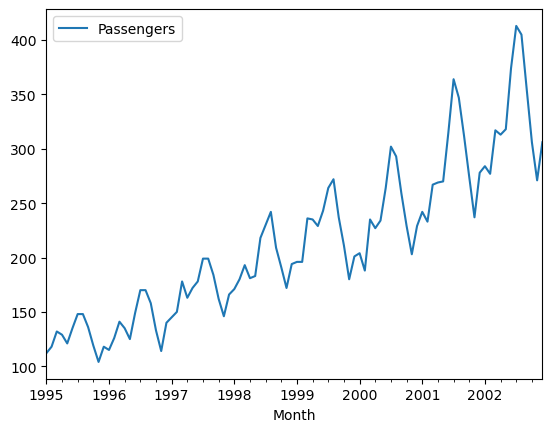

In [51]:
df.plot()

In [52]:
result=seasonal_decompose(df,model='multiplicaltive')

<Axes: xlabel='Month'>

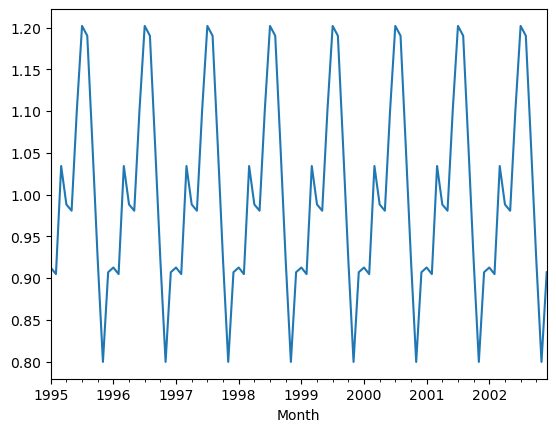

In [53]:
result.seasonal.plot()

<Axes: xlabel='Month'>

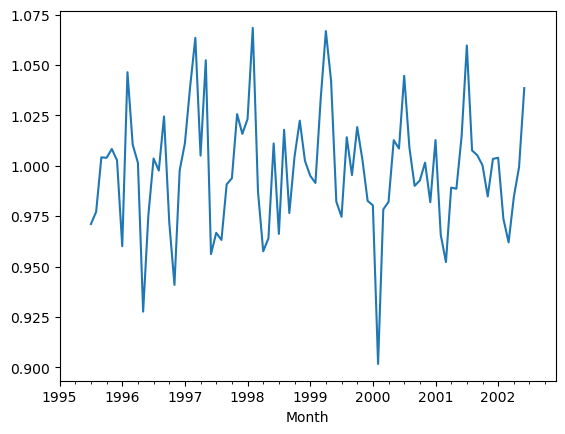

In [54]:
result.resid.plot()

<Axes: xlabel='Month'>

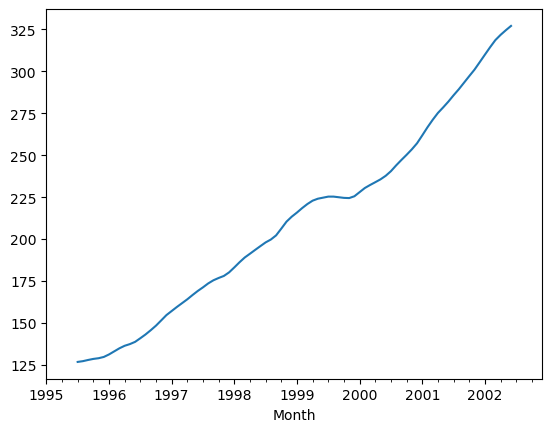

In [55]:
result.trend.plot()

#### H0=data is not stationary
#### H1=data is stationary

In [56]:
test=adfuller(df)
output=pd.Series(test[0:4],index=['stat','p_value','n_lags','total no of observations'])
print(output)

stat                         1.340248
p_value                      0.996825
n_lags                      12.000000
total no of observations    83.000000
dtype: float64


#### p-vlaue is greater than critical value
#### Hence data is not stationary

#### To make data stationary we go for log transformation and differencing

###### *log Transforamation

In [57]:
log=np.log(df)

<Axes: xlabel='Month'>

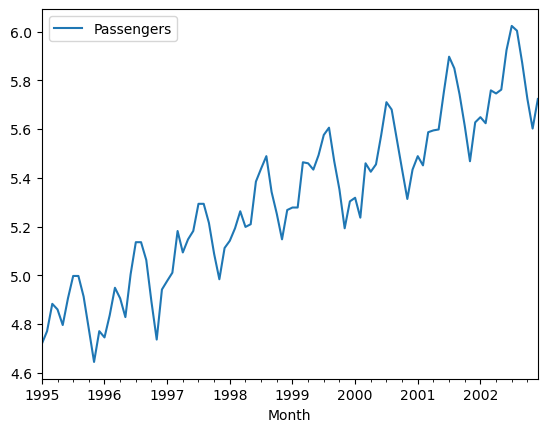

In [58]:
log.plot()

###### * Differencing

In [59]:
diff=log-log.rolling(window=12).mean()

In [60]:
diff.dropna(inplace=True)

In [61]:
diff2=diff-diff.rolling(window=12).mean()

In [62]:
diff2.dropna(inplace=True)

In [63]:
test=adfuller(diff2)
output=pd.Series(test[0:4],index=['stat','p_value','n_lags','total no of observations'])
print(output)

stat                        -2.263723
p_value                      0.183935
n_lags                      12.000000
total no of observations    61.000000
dtype: float64


<Axes: xlabel='Month'>

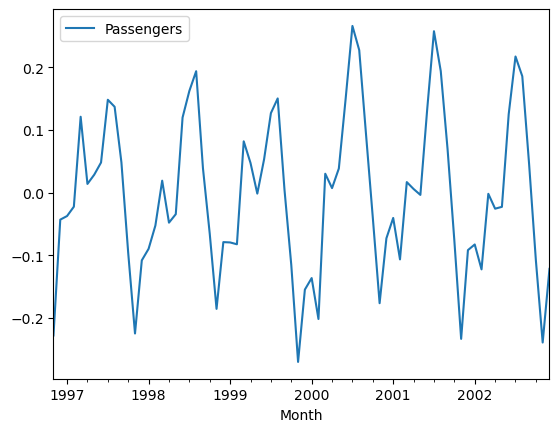

In [64]:
diff2.plot()

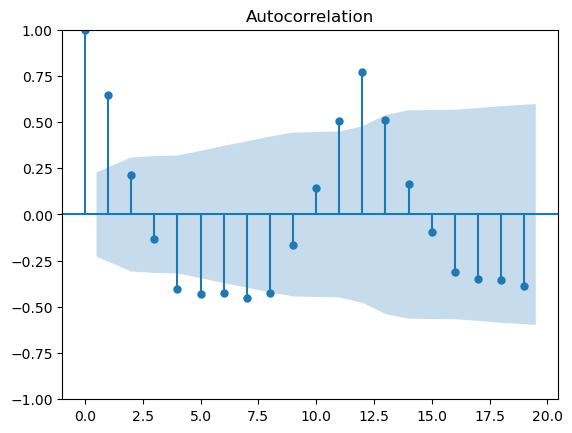

In [65]:
acf=plot_acf(diff2)

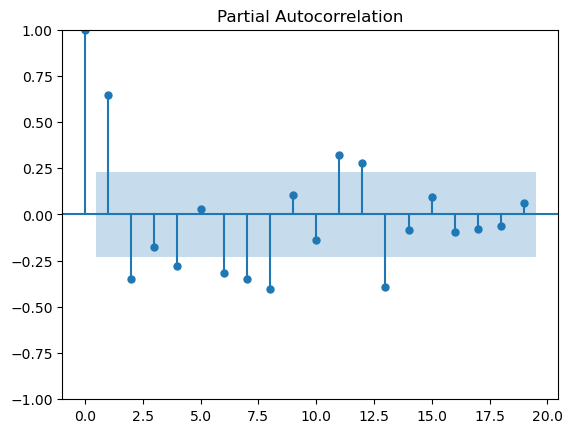

In [66]:
pacf=plot_pacf(diff2)

### SARIMAX

In [67]:
model=sm.tsa.SARIMAX(diff2,order=(1,2,1),seasonal_order=(1,2,1,12))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [68]:
results=model.fit()

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Creating dummy variables

In [69]:
test=pd.to_datetime(pd.Series(index=['2002-12-01','2003-01-01','2003-02-01','2003-03-01','2003-04-01','2003-05-01','2003-06-01','2003-06-01','2003-07-01','2003-08-01','2003-09-01','2003-10-01','2003-11-01','2003-12-01']))

C:\Users\Hp\AppData\Local\Temp\ipykernel_13140\3037621622.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test=pd.to_datetime(pd.Series(index=['2002-12-01','2003-01-01','2003-02-01','2003-03-01','2003-04-01','2003-05-01','2003-06-01','2003-06-01','2003-07-01','2003-08-01','2003-09-01','2003-10-01','2003-11-01','2003-12-01']))


In [70]:
test=pd.DataFrame(test)

In [71]:
test

,0
2002-12-01,NaT
2003-01-01,NaT
2003-02-01,NaT
2003-03-01,NaT
2003-04-01,NaT
2003-05-01,NaT
2003-06-01,NaT
2003-06-01,NaT
2003-07-01,NaT
2003-08-01,NaT


In [72]:
pred=results.predict(start=test.index[0],end=test.index[-1],dynamic=False,information_set='predicted',signal_only=False,)

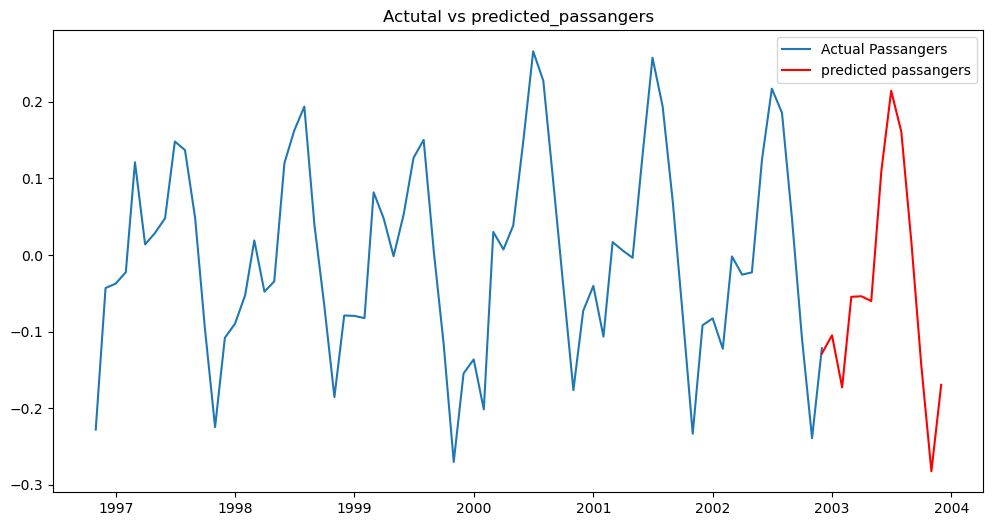

In [73]:
plt.figure(figsize=(12,6))
plt.plot(diff2['Passengers'],label='Actual Passangers')
plt.plot(pred,label='predicted passangers',color='red')
plt.legend()
plt.title('Actutal vs predicted_passangers')
plt.show()

In [74]:
print(len(diff2))

74


In [75]:
model=sm.tsa.SARIMAX(diff2[:50],order=(1,2,1),seasonal_order=(1,2,1,12))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [76]:
result=model.fit()

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [77]:
pred=result.predict(start=diff2.index[51],end=diff2.index[-1])

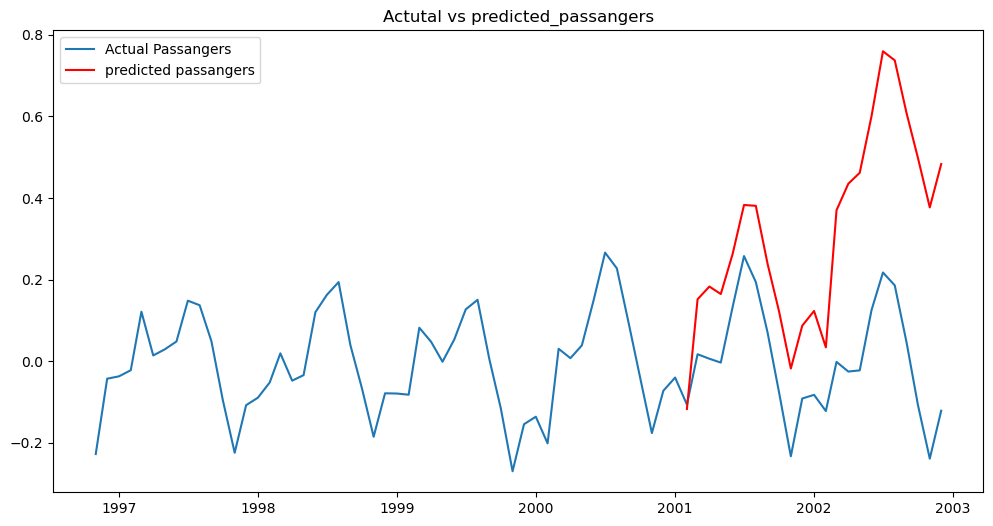

In [78]:
plt.figure(figsize=(12,6))
plt.plot(diff2['Passengers'],label='Actual Passangers')
plt.plot(pred,label='predicted passangers',color='red')
plt.legend()
plt.title('Actutal vs predicted_passangers')
plt.show()

In [79]:
rmse=sqrt(mean_squared_error(diff2[51:],pred))

In [80]:
rmse

0.3728335163008354

### ARIMA

In [81]:
model=sm.tsa.ARIMA(diff2[:50],order=(1,2,1))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [82]:
result=model.fit()

In [83]:
pred=result.predict(start=diff2.index[51],end=diff2.index[-1])

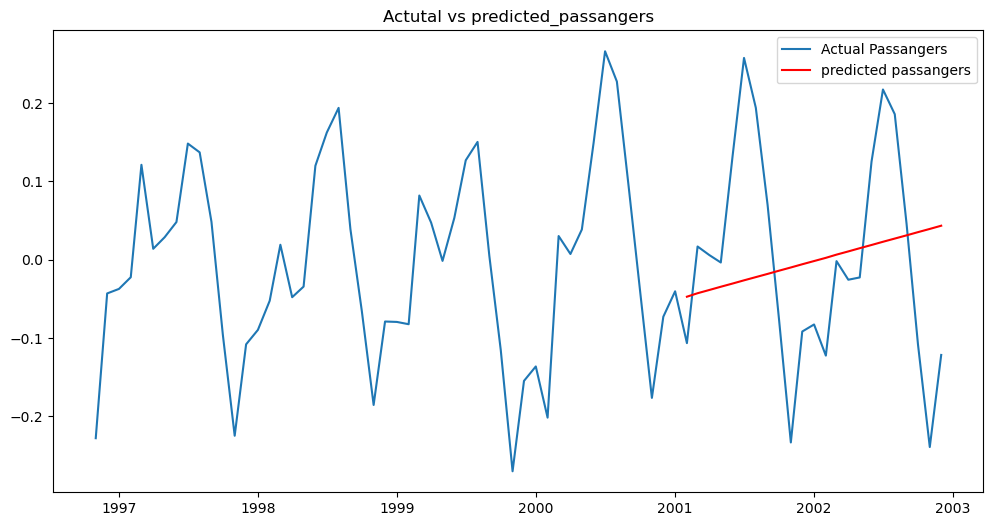

In [84]:
plt.figure(figsize=(12,6))
plt.plot(diff2['Passengers'],label='Actual Passangers')
plt.plot(pred,label='predicted passangers',color='red')
plt.legend()
plt.title('Actutal vs predicted_passangers')
plt.show()

In [85]:
rmse=sqrt(mean_squared_error(diff2[51:],pred))

In [86]:
rmse

0.141048944023069